# Breast Cancer Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import warnings
import time

start_time = time.time()
end_time = time.time()
run_time = end_time - start_time
print(f"代码运行时间: {run_time} 秒")
warnings.filterwarnings("ignore")

df = pd.read_excel('/kaggle/input/cancerdata/cancer.xlsx')
print(df)
end_time = time.time()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


代码运行时间: 4.291534423828125e-05 秒
      Column1 Column2  Column3  Column4  Column5  Column6  Column7  Column8  \
0      842302       M    17.99    10.38   122.80   1001.0  0.11840  0.27760   
1      842517       M    20.57    17.77   132.90   1326.0  0.08474  0.07864   
2    84300903       M    19.69    21.25   130.00   1203.0  0.10960  0.15990   
3    84348301       M    11.42    20.38    77.58    386.1  0.14250  0.28390   
4    84358402       M    20.29    14.34   135.10   1297.0  0.10030  0.13280   
..        ...     ...      ...      ...      ...      ...      ...      ...   
564    926424       M    21.56    22.39   142.00   1479.0  0.11100  0.11590   
565    926682       M    20.13    28.25   131.20   1261.0  0.09780  0.10340   
566    926954       M    16.60    28.08   108.30    858.1  0.08455  0.10230   
567    927241       M    20.60    29.33   140.10   1265.0  0.11780  0.27700   
568     92751       B     7.76    24.54    47.92    181.0  0.05263  0.04362   

     Column9  Colum

In [2]:
data = df.rename(columns={'Column1': 'ID', 'Column2': 'Y', 'Column3': 'radius1', 'Column4': 'texture1', 'Column5': 'perimeter1', 
                     'Column6': 'area1', 'Column7': 'smoothness1', 'Column8': 'compactness1', 'Column9': 'concavity1', 'Column10': 'concave_points1',
                     'Column11': 'symmetry1', 'Column12': 'fractal_dimension1', 'Column13': 'radius2', 'Column14': 'texture2', 'Column15': 'perimeter2', 
                     'Column16': 'area2', 'Column17': 'smoothness2', 'Column18': 'compactness2', 'Column19': 'concavity2', 'Column20': 'concave_points2',
                     'Column21': 'symmetry2', 'Column22': 'fractal_dimension2', 'Column23': 'radius3', 'Column24': 'texture3', 'Column25': 'perimeter3', 
                     'Column26': 'area3', 'Column27':'smoothness3', 'Column28': 'compactness3', 'Column29': 'concavity3', 'Column30': 'concave_points3',
                     'Column31': 'symmetry3', 'Column32': 'fractal_dimension3'})
data['Y'] = data['Y'].replace({'B': 0, 'M': 1})
data

,ID,Y,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [4]:
X = data.iloc[:,2:]
Y = data.iloc[:,1]
X = (X - X.mean()) / X.std()
X_knockoff = get_equi_features(X)
Y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: Y, Length: 569, dtype: int64

In [5]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['radius1', 'texture1', 'perimeter1', 
                'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1',
                'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 
                'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
                'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 
                'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
                'symmetry3', 'fractal_dimension3']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature
feature.to_csv('bigdata_feature.csv', index=False)
Y.to_csv('bigdata_Y.csv', index=False)

## Optimizers Selection

In [12]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 超参数
LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

# 神经网络定义
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(60, 10, 1)
net_Momentum = Net(60, 10, 1)
net_RMSprop = Net(60, 10, 1)
net_Adam = Net(60, 10, 1)
net_Adagrad = Net(60, 10, 1)
net_Adadelta = Net(60, 10, 1)

In [14]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


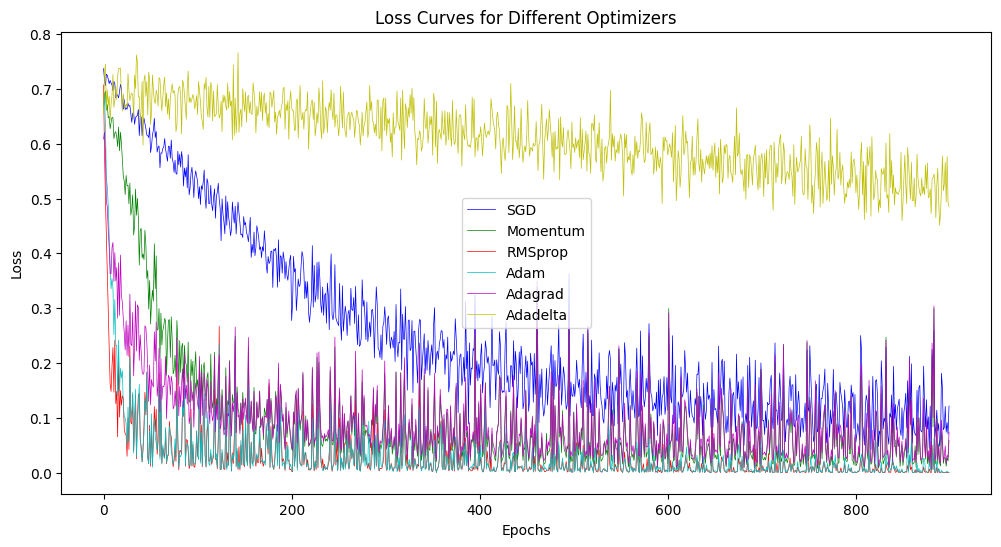

In [15]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves for Different Optimizers')
plt.show()

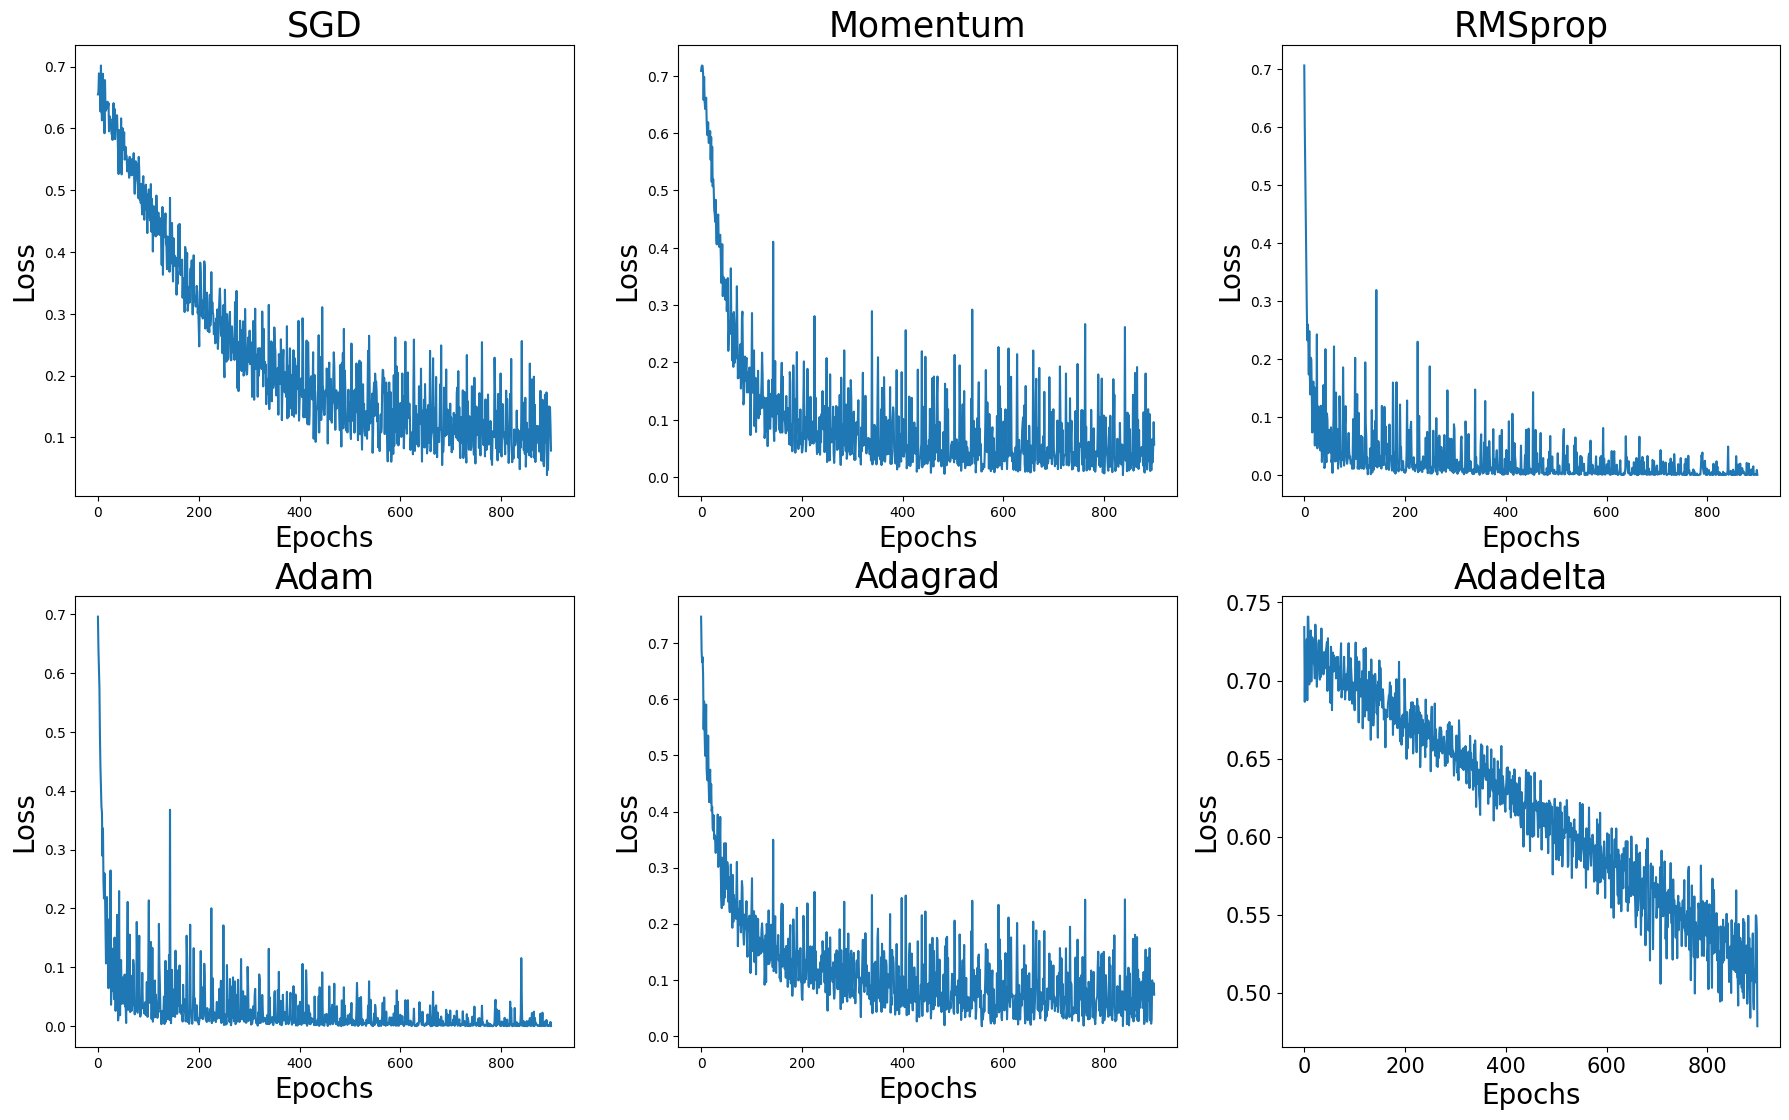

In [26]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history)
    ax.set_title(labels[i], fontsize = 25)
    ax.set_xlabel('Epochs', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.legend()

for ax in axes.flatten():
    ax.legend().set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
final_losses = [loss[-1] for loss in losses_his]
print("Final Losses:", final_losses)

## Adam & Momentum & Adagrad & RMSprop

## Adam

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((60,10))
input_dim = 60
for i in range(5, 20, 1):
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 5e-15 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[ 7. 13.  7. 11. 14.  0.  6. 10.  6. 19.]

 [10. 10.  5. 10.  0. 12.  0. 10.  6. 10.]

 [12.  6.  5. 10.  5.  9.  6.  0. 18. 10.]

 [12. 12.  5. 11. 17.  9.  6. 15.  6.  0.]

 [14. 10. 10.  9. 14.  9.  6. 15.  9. 10.]

 [ 7.  6.  5. 10.  5.  0. 11.  0.  9. 19.]

 [10. 17.  7. 10.  5.  9.  8. 15.  6. 10.]

 [ 7. 10.  5.  9.  5.  9. 11.  9.  6. 10.]

 [ 7.  7. 14. 10.  5.  9.  6. 15.  6.  0.]

 [14.  6.  5.  9.  0.  9. 11. 13.  6. 10.]

 [12.  6.  7. 10.  5.  9.  6.  9. 11. 10.]

 [ 7.  7.  8. 13. 14.  0.  6. 16.  9. 10.]

 [12.  6.  5.  9.  0.  9.  6. 10.  6. 18.]

 [ 7. 10.  5. 10.  0.  9.  6.  9.  6. 10.]

 [ 7. 10.  7.  9.  5.  0.  6. 18. 10. 10.]

 [ 7.  6.  7.  9.  0. 11.  6. 10.  6.  0.]

 [ 7.  6.  7. 10.  5. 11.  8. 13.  9. 19.]

 [12.  7.  8.  9.  5.  9.  6.  9.  6.  0.]

 [ 7. 13.  5.  9. 17.  0.  8.  9.  6. 10.]

 [12. 10.  5. 10.  5. 12.  6. 10.  6. 10.]

 [12.  7.  0. 10. 14. 11.  6. 10. 11. 10.]

 [10.  7. 14.  0.  5. 11.  8.  9.  6. 10.]

 [12. 10.  5.  9.  5.  9.  6.  9

In [52]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0

绝对值最大lambda值: 19.0


In [53]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 7.27633820229275e-20

绝对值最大权重值: 0.009324515238404274


### one layer

In [54]:
lambda_array = np.where(lambda_array == 0, 100, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+30]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+30]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.2:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1
#1 3 4 7 8 21 23 24 28

0 8 0.0

0 1 0.0

4 14 0.2857142857142857

0 8 0.0

5 19 0.2631578947368421

0 2 0.0

6 21 0.2857142857142857

7 23 0.30434782608695654

4 16 0.25

4 13 0.3076923076923077

5 20 0.25

1 10 0.1

0 8 0.0

4 17 0.23529411764705882

1 10 0.1

0 5 0.0

6 22 0.2727272727272727

5 18 0.2777777777777778

3 12 0.25

6 22 0.2727272727272727

1 9 0.1111111111111111

4 15 0.26666666666666666

4 17 0.23529411764705882

2 11 0.18181818181818182

5 20 0.25

3 12 0.25

2 11 0.18181818181818182

0 3 0.0

0 5 0.0

0 6 0.0

Variable is select:  1

Variable is select:  2

Variable is select:  4

Variable is select:  6

Variable is select:  12

Variable is select:  16

Variable is select:  21

Variable is select:  24

Variable is select:  28

Variable is select:  29

Variable is select:  30


0.0186

### multiple layers

In [64]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.3:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value
#1 3 4 7 8 21 23 24 28

([1, 2, 6, 21, 23, 24, 28, 29], array([21.220144], dtype=float32))

## Adagrad

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((60,10))
input_dim = 60
for i in range(5, 20, 1):
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-4 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0. 15.  0.  0.  0.  0.]

 [ 0. 14.  0.  0.  0. 15.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0. 17.  0.  0.  0.  7.  0.]

 [15.  0.  0.  0.  0. 18.  0. 11.  6. 10.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  7.  7.  0.  0. 13.  0. 15.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [19. 15.  0. 12.  0.  0.  0. 19. 16.  0.]

 [ 8.  0.  0.  0. 17.  0.  0. 17.  0.  0.]

 [ 0.  0.  0.  0.  0. 15.  0. 17.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 8.  7.  0. 16.  0.  0. 10. 19.  0. 14.]

 [ 0.  5.  0.  6.  0.  0.  0. 18.  0.  0.]

 [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]

 [ 0.  0.  0.  0.  0.  0.  0.  0

In [90]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0

绝对值最大lambda值: 19.0


In [91]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 1.0572407518338878e-06

绝对值最大权重值: 0.2360561341047287


### one layer

In [94]:
lambda_array = np.where(lambda_array == 0, 2501, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+20]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+20]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1
#1 3 4 7 8 21 23 24 28

0 15 0.0

3 18 0.16666666666666666

0 15 0.0

0 15 0.0

0 15 0.0

0 15 0.0

0 15 0.0

0 15 0.0

0 15 0.0

3 22 0.13636363636363635

0 15 0.0

4 24 0.16666666666666666

0 15 0.0

0 15 0.0

4 25 0.16

3 21 0.14285714285714285

3 20 0.15

0 15 0.0

4 26 0.15384615384615385

4 23 0.17391304347826086

3 19 0.15789473684210525

3 18 0.16666666666666666

0 15 0.0

0 15 0.0

0 15 0.0

0 15 0.0

3 16 0.1875

0 15 0.0

0 15 0.0

3 22 0.13636363636363635

Variable is select:  1

Variable is select:  3

Variable is select:  6

Variable is select:  7

Variable is select:  8

Variable is select:  11

Variable is select:  13

Variable is select:  14

Variable is select:  18

Variable is select:  23

Variable is select:  24

Variable is select:  25

Variable is select:  26

Variable is select:  28

Variable is select:  29


2.501

### multiple layers

In [98]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.1:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value
#1 3 4 7 8 21 23 24 28

([2, 4, 8, 9, 24], array([32229152.], dtype=float32))

## Momentum

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((60,10))
input_dim = 60
for i in range(5, 20, 1):
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(10, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-8 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0. 17.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0

In [177]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0

绝对值最大lambda值: 17.0


In [178]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 3.247976110287709e-08

绝对值最大权重值: 0.0019238186068832874


### one layer

In [179]:
lambda_array = np.where(lambda_array == 0, 100, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+30]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+30]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.1:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1
#1 3 4 7 8 21 23 24 28

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 30 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

0 29 0.0

Variable is select:  1

Variable is select:  2

Variable is select:  3

Variable is select:  4

Variable is select:  5

Variable is select:  6

Variable is select:  7

Variable is select:  8

Variable is select:  9

Variable is select:  10

Variable is select:  11

Variable is select:  12

Variable is select:  13

Variable is select:  14

Variable is select:  15

Variable is select:  16

Variable is select:  17

Variable is select:  18

Variable is select:  19

Variable is select:  20

Variable is select:  21

Variable is select:  22

Variable is select:  23

Variable is select:  24

Variable is select:  25

Variable is select:  26

Variable is select:  27

Variable is select:  28

Variable 

0.0917

### multiple layers

In [181]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.1:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value
#1 3 4 7 8 21 23 24 28

([21, 23, 24, 27, 28], array([24.97572], dtype=float32))

### RMSprop

In [171]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((60,10))
input_dim = 60
for i in range(5, 20, 1):
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-6 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

 [ 0.  0.  0.  0.  0.  0.  0.  0

In [172]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0

绝对值最大lambda值: 12.0


In [173]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 5.458990926854312e-06

绝对值最大权重值: 0.008178213611245155


### one layer

In [174]:
lambda_array = np.where(lambda_array == 0, 2501, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+30]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+30]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

0 30 0.0

Variable is select:  1

Variable is select:  2

Variable is select:  3

Variable is select:  4

Variable is select:  5

Variable is select:  6

Variable is select:  7

Variable is select:  8

Variable is select:  9

Variable is select:  10

Variable is select:  11

Variable is select:  12

Variable is select:  13

Variable is select:  14

Variable is select:  15

Variable is select:  16

Variable is select:  17

Variable is select:  18

Variable is select:  19

Variable is select:  20

Variable is select:  21

Variable is select:  22

Variable is select:  23

Variable is select:  24

Variable is select:  25

Variable is select:  26

Variable is select:  27

Variable is select:  28

Variable 

2.501

### multiple layers

In [175]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+10]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.1:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value
#1 3 4 7 8 21 23 24 28

([8, 21, 22, 23, 24, 28], array([413064.6], dtype=float32))

## VWA Filter

In [9]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

X = X
y = Y

num_variables = X.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(25):
        model = keras.Sequential()
        model.add(layers.Dense(300, input_shape=(input_dim,)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)  # 设置 verbose 参数为 0
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)

    #print(f"For variable {x_index + 1}:")
    #print("Average accuracy:", avg_accuracy * 100, "%")
    
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)

18/18 [==============================] - 0s 1ms/step
Accuracies for each variable: [0.5254833040421792, 1.0, 0.873884007029877, 0.6834446397188049, 0.8506151142355008, 0.8243936731107206, 0.6415465729349735, 0.8001405975395431, 0.8788752196836556, 0.9070650263620387, 0.6776801405975396, 0.6274165202108963, 0.8144815465729348, 0.6274165202108963, 0.8024604569420035, 0.8676977152899825, 0.6274165202108963, 0.6423198594024605, 0.6501933216168717, 0.6518804920913884, 0.6274165202108963, 0.6274165202108963, 0.9102987697715291, 0.7062214411247802, 0.8903339191564149, 0.8120913884007028, 0.7039015817223199, 0.7961335676625658, 0.8477328646748683, 0.9097363796133568, 0.7131107205623901]


### one-layer

In [24]:
from collections import defaultdict

lists = [
    [1,2,4,6,12,16,21,24,28,29,30],
    [1,3,6,7,8,11,13,14,18,23,24,25,26,28,29]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")
for variable, weight in sorted_variable_weights:
    print(f"Variable {variable}: {weight}")

Variable weights sorted:
Variable 1: 0.08503833450404269
Variable 29: 0.0773624665600574
Variable 24: 0.0757125136375185
Variable 28: 0.07208979091629181
Variable 6: 0.0545560520691665
Variable 8: 0.037369042459386353
Variable 2: 0.037156820253769936
Variable 4: 0.0361674463092765
Variable 12: 0.034631077102419625
Variable 25: 0.03452944956733571
Variable 14: 0.03411995038185052
Variable 7: 0.03402131189191613
Variable 30: 0.03032087399680172
Variable 23: 0.030027947572148075
Variable 26: 0.02992930908221369
Variable 3: 0.029059496943701333
Variable 18: 0.02764567858797507
Variable 16: 0.02667722795952833
Variable 21: 0.02667722795952833
Variable 11: 0.02667722795952833
Variable 13: 0.02667722795952833


### multiple-layers

In [25]:
from collections import defaultdict

lists = [
    [1, 2, 6, 21, 23, 24, 28, 29],
    [2, 4, 8, 9, 24],
    [21, 23, 24, 27, 28],
    [8, 21, 22, 23, 24, 28]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")
for variable, weight in sorted_variable_weights:
    print(f"Variable {variable}: {weight}")

Variable weights sorted:
Variable 24: 0.151425027275037
Variable 28: 0.10813468637443771
Variable 23: 0.09008384271644422
Variable 21: 0.08003168387858499
Variable 8: 0.07473808491877271
Variable 2: 0.07431364050753987
Variable 1: 0.042519167252021345
Variable 22: 0.03870514564122492
Variable 29: 0.0386812332800287
Variable 9: 0.03856764956434667
Variable 4: 0.0361674463092765
Variable 27: 0.03385093631839309
Variable 6: 0.02727802603458325


### one-layer and multiple layers

In [26]:
from collections import defaultdict

lists = [
    [1,2,4,6,12,16,21,24,28,29,30],
    [1, 2, 6, 21, 23, 24, 28, 29],
    [1,3,6,7,8,11,13,14,18,23,24,25,26,28,29],
    [2, 4, 8, 9, 24],
    [21, 23, 24, 27, 28],
    [8, 21, 22, 23, 24, 28]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")
for variable, weight in sorted_variable_weights:
    print(f"Variable {variable}: {weight}")

Variable weights sorted:
Variable 24: 0.22713754091255553
Variable 28: 0.18022447729072952
Variable 1: 0.12755750175606403
Variable 23: 0.1201117902885923
Variable 29: 0.11604369984008608
Variable 8: 0.11210712737815906
Variable 2: 0.11147046076130981
Variable 21: 0.10670891183811332
Variable 6: 0.08183407810374975
Variable 4: 0.072334892618553
Variable 22: 0.03870514564122492
Variable 9: 0.03856764956434667
Variable 12: 0.034631077102419625
Variable 25: 0.03452944956733571
Variable 14: 0.03411995038185052
Variable 7: 0.03402131189191613
Variable 27: 0.03385093631839309
Variable 30: 0.03032087399680172
Variable 26: 0.02992930908221369
Variable 3: 0.029059496943701333
Variable 18: 0.02764567858797507
Variable 16: 0.02667722795952833
Variable 11: 0.02667722795952833
Variable 13: 0.02667722795952833
